<a href="https://colab.research.google.com/github/zihanltesla/Deep-Learning/blob/main/AI_Generated_Text_Detection_via_Disentangled_Style_Content_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.jsonl to train.jsonl


In [1]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 89.8 MB/s eta 0:00:00


In [3]:
import pandas as pd

df = pd.read_json("train.jsonl", lines=True)
print(df.columns)
print(df[:10])

Index(['id', 'text', 'model', 'label', 'genre'], dtype='object')
                                     id  \
0  ea468d03-1973-5039-86b2-ff225bb92c4e   
1  0d05f269-6d67-521d-9b5d-cc18f482c6c1   
2  c2ec79f3-da80-58f8-bef0-3e0ea7ab072f   
3  4ad37c58-0bb7-536b-997d-cfccabd0d094   
4  07747b0c-5051-5e0d-8096-b4d4ed8bd98e   
5  5a72d2c9-2e5d-53e0-ba2d-e211c172878c   
6  6a90d63b-803b-506f-92ab-1a7612739c14   
7  6a27a41f-d4c0-5421-87e0-8283f0c4eb5c   
8  fdc88dc8-4fd1-5f5f-988e-6a5bdc300e3c   
9  0c3e22e1-c697-5032-b73e-d6c9aed02aaf   

                                                text  \
0  Duke Ellington, a titan of jazz, revolutionize...   
1  I reflected on the shifting dynamics of media ...   
2  In F. Scott Fitzgerald's "The Great Gatsby," t...   
3  I still chuckle when I think about that time I...   
4  Yoga, originating in ancient India, encompasse...   
5  As I delve into the complexities of John Rando...   
6  A recent study explored the prevalent issue of...   
7  Sleep diso

In [4]:
df = df[["text", "label"]]
print(df["label"].unique())

[1 0]


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df.to_csv("/content/drive/My Drive/training_dataset.csv", index=False)

Mounted at /content/drive


NameError: name 'df' is not defined

In [4]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
train_df = pd.read_csv("/content/drive/My Drive/training_dataset.csv")
train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,"Duke Ellington, a titan of jazz, revolutionize...",1
1,I reflected on the shifting dynamics of media ...,1
2,"In F. Scott Fitzgerald's ""The Great Gatsby,"" t...",1
3,I still chuckle when I think about that time I...,1
4,"Yoga, originating in ancient India, encompasse...",1


In [7]:
from google.colab import files
uploaded = files.upload()

Saving val.jsonl to val.jsonl


In [8]:
import pandas as pd

df = pd.read_json("val.jsonl", lines=True)
print(df.columns)

Index(['id', 'text', 'model', 'label', 'genre'], dtype='object')


In [9]:
df = df[["text", "label"]]
print(df["label"].unique())

[1 0]


In [10]:
from google.colab import drive
drive.mount('/content/drive')
df.to_csv("/content/drive/My Drive/validation_dataset.csv", index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
val_df = pd.read_csv("/content/drive/My Drive/validation_dataset.csv")
val_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,text,label
0,"In William Faulkner's ""The Sound and the Fury,...",1
1,"Manipulation, a profound and pervasive theme i...",1
2,Edna's journey is a testament to her rebellion...,1
3,There are three main aspects of the gun contro...,0
4,During the Portuguese colonial period in Angol...,1


In [12]:
import pandas as pd
import spacy
import textstat
import numpy as np
import re
from tqdm import tqdm
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")

slang = {"lol", "brb", "idk", "imo", "smh", "tbh", "rofl", "lmao"}
uppercase_pattern = re.compile(r"[A-Z]{2,}")
url_pattern = re.compile(r"https?://|www\.")
subject_pronouns = {"i", "we", "you", "he", "she", "they", "it"}
function_words = {"the", "is", "and", "but", "or", "because", "as", "that"}

def extract_features(text):
    doc = nlp(text)

    punctuation_count = sum(1 for char in text if char in ".,!?;:-")
    uppercase_ratio = len(uppercase_pattern.findall(text)) / (len(text) + 1)
    url_count = len(url_pattern.findall(text))
    slang_count = sum(1 for token in doc if token.text.lower() in slang)

    tokens = [token.text.lower() for token in doc if token.is_alpha]
    type_token_ratio = len(set(tokens)) / (len(tokens) + 1) if tokens else 0

    function_word_count = sum(1 for token in doc if token.text.lower() in function_words)

    sentence_lengths = [len(sent) for sent in doc.sents]
    avg_sentence_length = np.mean(sentence_lengths) if sentence_lengths else 0
    readability_score = textstat.flesch_reading_ease(text)

    has_subject = 0
    is_pronoun_subject = 0
    is_noun_subject = 0
    for token in doc:
        if token.dep_ in {"nsubj", "nsubjpass"}:
            has_subject = 1
            if token.text.lower() in subject_pronouns:
                is_pronoun_subject = 1
            else:
                is_noun_subject = 1
            break

    return [
        function_word_count,
        punctuation_count,
        type_token_ratio,
        avg_sentence_length,
        readability_score,
        uppercase_ratio,
        slang_count,
        url_count,
        has_subject,
        is_pronoun_subject,
        is_noun_subject
    ]


train_df["features"] = train_df["text"].progress_apply(extract_features)

val_df["features"] = val_df["text"].progress_apply(extract_features)

train_df.to_pickle("/content/drive/My Drive/ai_detect_train.pkl")
val_df.to_pickle("/content/drive/My Drive/ai_detect_val.pkl")

print("Feature extraction completed!")


100%|██████████| 3589/3589 [06:39<00:00,  8.99it/s]


Feature extraction completed!


In [5]:
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer
import pandas as pd

class AIDetectionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512, mode="train"):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.mode = mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row["text"]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        features = torch.tensor(row["features"], dtype=torch.float)

        if self.mode == "train":
            label = torch.tensor(row["label"], dtype=torch.long)
            return {
                "input_ids": encoded["input_ids"].squeeze(0),
                "attention_mask": encoded["attention_mask"].squeeze(0),
                "features": features,
                "labels": label
            }
        else:
            return {
                "input_ids": encoded["input_ids"].squeeze(0),
                "attention_mask": encoded["attention_mask"].squeeze(0),
                "features": features
            }


In [6]:
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive')

tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")


train_df = pd.read_pickle("/content/drive/My Drive/ai_detect_train.pkl")
val_df = pd.read_pickle("/content/drive/My Drive/ai_detect_val.pkl")

train_dataset = AIDetectionDataset(train_df, tokenizer, mode="train")
val_dataset = AIDetectionDataset(val_df, tokenizer, mode="train")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score

class SingleInputFactorizedAttentionModel(nn.Module):
    def __init__(self,
                 pretrained_model_name="microsoft/deberta-v3-small",
                 num_handcrafted_features=11,
                 hidden_dim=256,
                 dropout=0.1):
        super().__init__()

        # Pretrained encoder
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        hidden_size = self.encoder.config.hidden_size

        # Style and Content attention
        self.style_attention = nn.Linear(hidden_size, 1)
        self.content_attention = nn.Linear(hidden_size, 1)

        # Projections
        self.style_proj = nn.Linear(hidden_size, hidden_dim)
        self.content_proj = nn.Linear(hidden_size, hidden_dim)
        self.feature_proj = nn.Linear(num_handcrafted_features, hidden_dim)

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(3 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, input_ids, attention_mask, features, return_loss=False, labels=None):
        # BERT encoding
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        # Attention weights
        style_weights = torch.softmax(self.style_attention(hidden_states).squeeze(-1), dim=1)
        content_weights = torch.softmax(self.content_attention(hidden_states).squeeze(-1), dim=1)

        # Weighted sum
        style_repr = torch.sum(style_weights.unsqueeze(-1) * hidden_states, dim=1)
        content_repr = torch.sum(content_weights.unsqueeze(-1) * hidden_states, dim=1)

        # Projection
        style_vec = self.style_proj(style_repr)
        content_vec = self.content_proj(content_repr)
        feat_vec = self.feature_proj(features)

        # Final concat
        joint_repr = torch.cat([style_vec, content_vec, feat_vec], dim=1)
        logits = self.classifier(joint_repr)

        # Output
        if return_loss and labels is not None:
            # Orthogonality loss
            ortho_loss = torch.mean(torch.sum(style_vec * content_vec, dim=1) ** 2)

            # Feature alignment loss
            align_loss = torch.mean((style_vec - feat_vec) ** 2)

            # Classification loss
            cls_loss = nn.CrossEntropyLoss()(logits, labels)

            total_loss = cls_loss + 0.01 * ortho_loss + 0.01 * align_loss
            return logits, total_loss
        else:
            return logits


In [16]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()

def train_model(model, train_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        torch.cuda.empty_cache()
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            features = batch["features"].to(device)
            labels = batch["labels"].to(device)

            with autocast():
                logits, loss = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    features=features,
                    return_loss=True,
                    labels=labels
                )

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs} | Avg Loss: {total_loss / len(train_loader):.4f}")

/tmp/ipython-input-16-3801765980.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [17]:
@torch.no_grad()
def evaluate_model(model, val_loader, device):
    model.eval()
    preds, targets = [], []

    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        features = batch["features"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask, features=features)
        pred_labels = torch.argmax(logits, dim=1)

        preds.extend(pred_labels.cpu().tolist())
        targets.extend(labels.cpu().tolist())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="macro")
    print(f"Validation Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")
    return acc, f1

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SingleInputFactorizedAttentionModel().to(device)
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)


train_model(model, train_loader, optimizer, device, epochs=3)
evaluate_model(model, val_loader, device)

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

/tmp/ipython-input-16-3801765980.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/3 | Avg Loss: 5.7683
Epoch 2/3 | Avg Loss: 4.4311
Epoch 3/3 | Avg Loss: 3.5207
Validation Accuracy: 0.9412 | Macro F1: 0.9333


(0.941209250487601, 0.9332692531209803)

compare with baseline model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# load data
train_df = pd.read_pickle("/content/drive/My Drive/ai_detect_train.pkl")
val_df = pd.read_pickle("/content/drive/My Drive/ai_detect_val.pkl")

X_train = pd.DataFrame(train_df["features"].tolist())
y_train = train_df["label"]
X_val = pd.DataFrame(val_df["features"].tolist())
y_val = val_df["label"]

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC()
}
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="macro")
    results.append((name, acc, f1))
    print(f"{name} → Accuracy: {acc:.4f}, Macro F1: {f1:.4f}")

results.append(("DeBERTa + Attention", 0.9412, 0.9333))

Logistic Regression → Accuracy: 0.7983, Macro F1: 0.7733
Random Forest → Accuracy: 0.8507, Macro F1: 0.8346
Naive Bayes → Accuracy: 0.7425, Macro F1: 0.7051
SVM → Accuracy: 0.8158, Macro F1: 0.7889


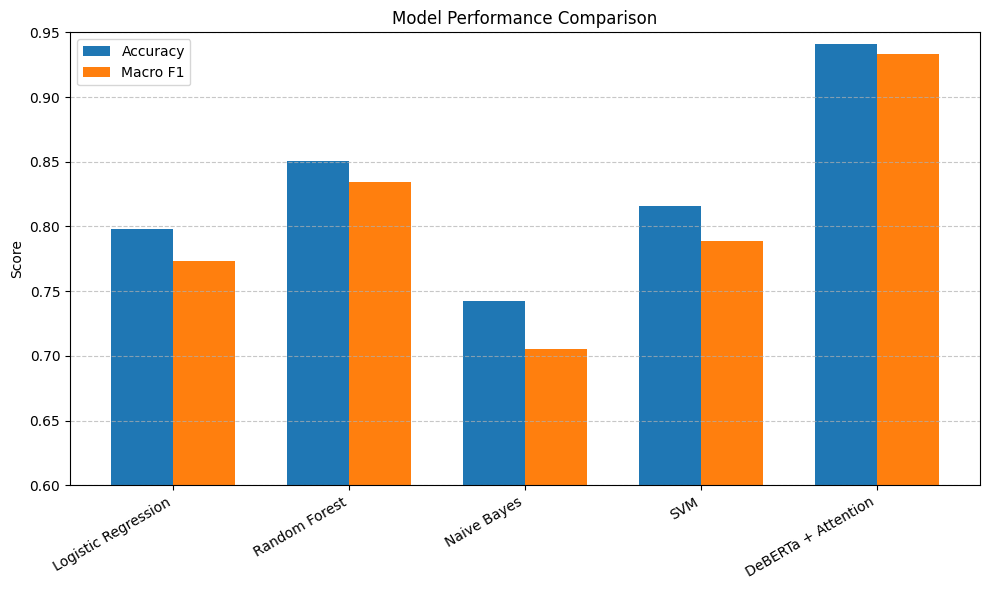

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1"])

plt.figure(figsize=(10, 6))
bar_width = 0.35
x = range(len(df))

plt.bar([i - bar_width/2 for i in x], df["Accuracy"], width=bar_width, label="Accuracy")
plt.bar([i + bar_width/2 for i in x], df["Macro F1"], width=bar_width, label="Macro F1")

plt.xticks(ticks=x, labels=df["Model"], rotation=30, ha='right')
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.ylim(0.6, 0.95)
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

We conducted an ablation study by removing the handcrafted linguistic features from our model. In this variant, the model only relies on the contextual representations derived from the disentangled style and content attention mechanisms, without incorporating features such as readability, punctuation usage, or sentence length. This change reduced the input to the final classifier and helped isolate the contribution of handcrafted features to overall model performance.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, f1_score
class AblatedModel_NoFeatures(nn.Module):
    def __init__(self,
                 pretrained_model_name="microsoft/deberta-v3-small",
                 hidden_dim=256,
                 dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        hidden_size = self.encoder.config.hidden_size

        self.style_attention = nn.Linear(hidden_size, 1)
        self.content_attention = nn.Linear(hidden_size, 1)

        self.style_proj = nn.Linear(hidden_size, hidden_dim)
        self.content_proj = nn.Linear(hidden_size, hidden_dim)

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2 * hidden_dim, hidden_dim),  # changed input size
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, input_ids, attention_mask, labels=None, return_loss=False,**kwargs):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        style_weights = torch.softmax(self.style_attention(hidden_states).squeeze(-1), dim=1)
        content_weights = torch.softmax(self.content_attention(hidden_states).squeeze(-1), dim=1)

        style_repr = torch.sum(style_weights.unsqueeze(-1) * hidden_states, dim=1)
        content_repr = torch.sum(content_weights.unsqueeze(-1) * hidden_states, dim=1)

        style_vec = self.style_proj(style_repr)
        content_vec = self.content_proj(content_repr)

        joint_repr = torch.cat([style_vec, content_vec], dim=1)
        logits = self.classifier(joint_repr)

        if return_loss and labels is not None:
            cls_loss = nn.CrossEntropyLoss()(logits, labels)
            return logits, cls_loss
        else:
            return logits


In [14]:
from sklearn.metrics import accuracy_score, f1_score
import torch

@torch.no_grad()
def evaluate_model_no_features(model, val_loader, device):
    model.eval()
    preds, targets = [], []

    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        pred_labels = torch.argmax(logits, dim=1)

        preds.extend(pred_labels.cpu().tolist())
        targets.extend(labels.cpu().tolist())

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="macro")
    print(f"[Ablation] Validation Accuracy: {acc:.4f} | Macro F1: {f1:.4f}")
    return acc, f1


In [17]:
from torch.cuda.amp import autocast, GradScaler

scaler = GradScaler()
def train_model_no_features(model, train_loader, optimizer, device, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        torch.cuda.empty_cache()
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with autocast():
                logits, loss = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    return_loss=True,
                    labels=labels
                )

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()

        print(f"[Ablation] Epoch {epoch + 1}/{epochs} | Avg Loss: {total_loss / len(train_loader):.4f}")


/tmp/ipython-input-17-3216153383.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ablation_model = AblatedModel_NoFeatures().to(device)
optimizer = AdamW(ablation_model.parameters(), lr=1e-5, weight_decay=1e-4)
train_model_no_features(ablation_model, train_loader, optimizer, device, epochs=3)
acc_ablation, f1_ablation = evaluate_model_no_features(ablation_model, val_loader, device)

/tmp/ipython-input-17-3216153383.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Ablation] Epoch 1/3 | Avg Loss: 0.0800
[Ablation] Epoch 2/3 | Avg Loss: 0.0250
[Ablation] Epoch 3/3 | Avg Loss: 0.0155
[Ablation] Validation Accuracy: 0.9635 | Macro F1: 0.9592
